In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Stock/adrd.us.csv').fillna('ffill')
df = df.sort_index(ascending=False)
df.index = range(len(df))
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2017-11-10,22.750,23.020,22.75,22.960,2378,0
1,2017-11-09,23.000,23.000,22.89,22.890,4997,0
2,2017-11-08,23.010,23.050,23.01,23.050,810,0
3,2017-11-07,23.113,23.113,22.99,22.990,16159,0
4,2017-11-06,23.000,23.225,23.00,23.225,4532,0


# Decomposition

<Figure size 1152x576 with 0 Axes>

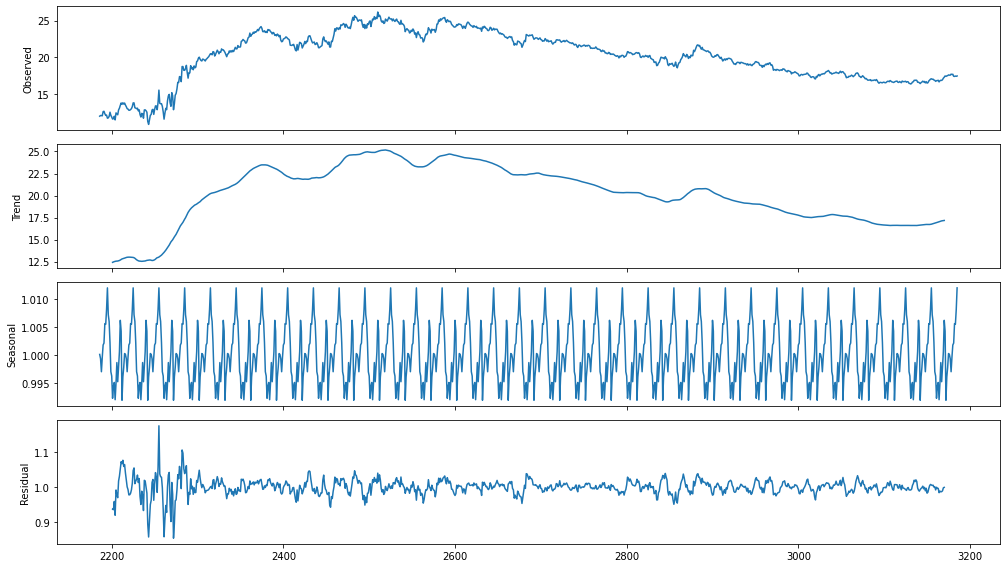

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
df_open = df['Close']
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_open[-1000:], model='multiplicative', freq=30)
plt.figure(figsize=(16, 8))
fig = result.plot()
plt.show()

# Plotting autocorrelation

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.655951
t+1  0.655951  1.000000


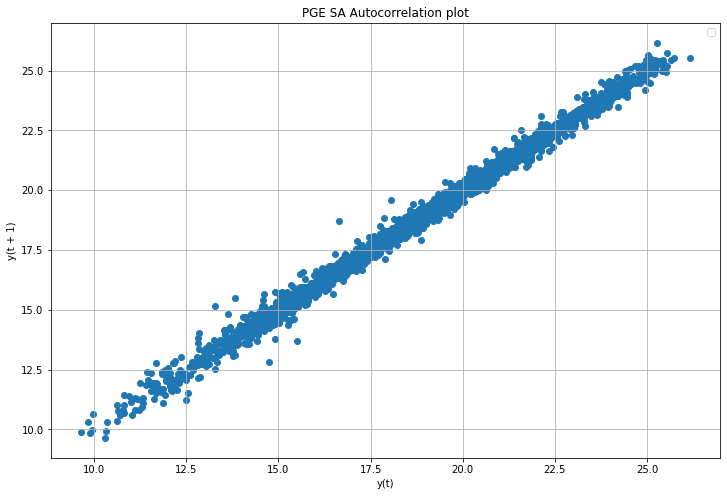

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12, 8))
lag_plot(df['Close'], lag=1)
plt.title('PGE SA Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(df['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

# features

In [ ]:
ma_list = [5,10,20,50,100,200]
for ma in ma_list:
    df['Open_ma_' + str(ma)] = df['Open'].rolling(ma).mean()
    df['High_ma_' + str(ma)] = df['High'].rolling(ma).mean()
    df['Low_ma_' + str(ma)] = df['Low'].rolling(ma).mean()
    df['Close_ma_' + str(ma)] = df['Close'].rolling(ma).mean()
df=df.dropna()
print(df)

           Date    Open    High     Low   Close  Volume  OpenInt  Open_ma_5  \
199  2017-01-25  19.996  20.152  19.939  20.093   10740        0    19.9006   
200  2017-01-24  19.898  19.928  19.796  19.889    4054        0    19.9200   
201  2017-01-23  19.752  19.873  19.752  19.869    7068        0    19.9218   
202  2017-01-20  19.908  19.908  19.772  19.811   13572        0    19.9140   
203  2017-01-19  19.879  19.879  19.731  19.752    4935        0    19.8866   
...         ...     ...     ...     ...     ...     ...      ...        ...   
3181 2005-03-03  17.417  17.425  17.386  17.386    3476        0    17.5896   
3182 2005-03-02  17.378  17.410  17.370  17.370    3994        0    17.5772   
3183 2005-03-01  17.425  17.425  17.395  17.417    3086        0    17.4466   
3184 2005-02-28  17.635  17.635  17.301  17.386   13329        0    17.5074   
3185 2005-02-25  17.331  17.440  17.331  17.433    7486        0    17.4372   

      High_ma_5  Low_ma_5  ...  Low_ma_50  Close_ma

# Shift label column

In [ ]:
df['1day'] = df['Close'].shift(-1)

# Split data

In [ ]:
test_size = 0.2

test_split_idx = int(df.shape[0] * (1-test_size))

train_df = df.loc[:test_split_idx].copy()
test_df = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Open, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Date, y=test_df.Open, name='Test'))

# Drop unnecessary columns

In [ ]:
drop_cols = ['Date', 'Volume', 'OpenInt']
train_df = train_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

# Select best features

In [ ]:
y_train = train_df['1day']
X_train = train_df.drop('1day',1)

y_test = test_df['1day']
X_test = test_df.drop('1day',1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 199 to 2389
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2191 non-null   float64
 1   High          2191 non-null   float64
 2   Low           2191 non-null   float64
 3   Close         2191 non-null   float64
 4   Open_ma_5     2191 non-null   float64
 5   High_ma_5     2191 non-null   float64
 6   Low_ma_5      2191 non-null   float64
 7   Close_ma_5    2191 non-null   float64
 8   Open_ma_10    2191 non-null   float64
 9   High_ma_10    2191 non-null   float64
 10  Low_ma_10     2191 non-null   float64
 11  Close_ma_10   2191 non-null   float64
 12  Open_ma_20    2191 non-null   float64
 13  High_ma_20    2191 non-null   float64
 14  Low_ma_20     2191 non-null   float64
 15  Close_ma_20   2191 non-null   float64
 16  Open_ma_50    2191 non-null   float64
 17  High_ma_50    2191 non-null   float64
 18  Low_ma_50     2191 non-nul

# Select parameter

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in

Max Score：0.7690618513906186 Subtree number is：25


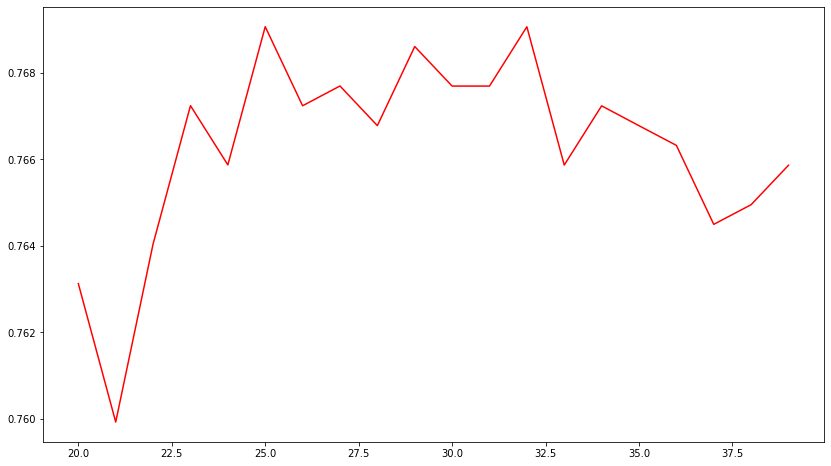

In [ ]:
score_lt = []

for i in range(20,40):
    rfc = RandomForestClassifier(n_estimators=i+1 ,random_state=90)
    score = cross_val_score(rfc, X_train, y_train.astype('int'), cv=10,error_score='raise').mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Max Score：{}'.format(score_max),
      'Subtree number is：{}'.format(score_lt.index(score_max)+20))

# 绘制学习曲线
x = np.arange(20,40)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

In [ ]:
rfc = RandomForestClassifier(n_estimators=25, random_state=90)

param_grid = {'max_depth':np.arange(1,20)}
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(X_train,y_train.astype('int'))

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.



{'max_depth': 6} 0.8160938148609382


In [ ]:
X_train.shape

(2191, 28)

In [ ]:
param_grid = {'max_features':np.arange(5,29)}

rfc = RandomForestClassifier(n_estimators=25
                            ,random_state=90
                            ,max_depth=6)
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(X_train,y_train.astype('int'))
best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.



{'max_features': 16} 0.8311540058115401


# Fine-tune RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
param_grid={'bootstrap': [True],
 'max_depth': [6],
 'max_features': [16],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [25]}
tscv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = tscv, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'bootstrap': True,
 'max_depth': 6,
 'max_features': 16,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 25}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
param_grid={'bootstrap': [True],
 'max_depth': [6],
 'max_features': [16],
 'n_estimators': [25]}
tscv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = tscv, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'bootstrap': True, 'max_depth': 6, 'max_features': 16, 'n_estimators': 25}

In [ ]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=16, n_estimators=25)

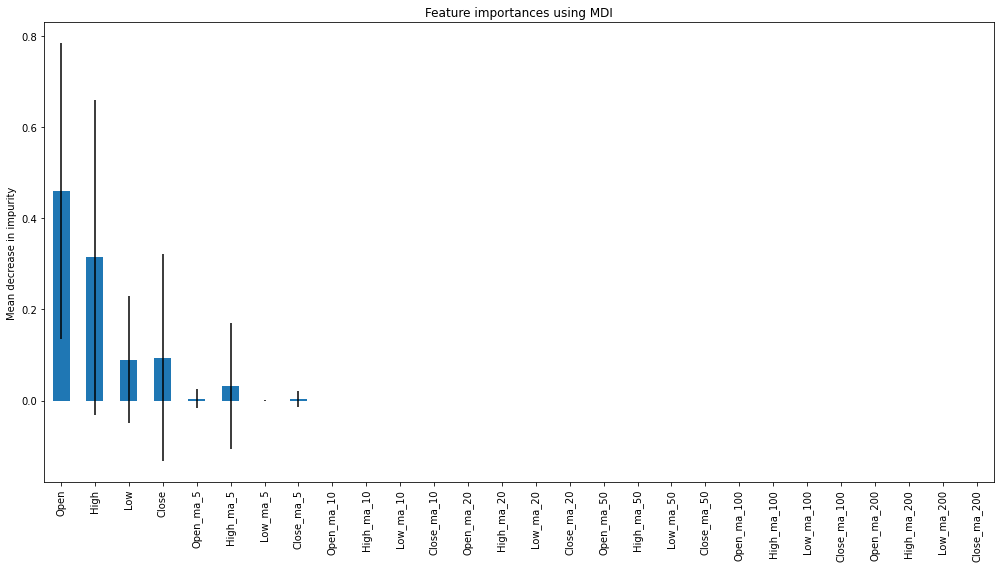

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()